# Problem 2: An SNN tackling a real-world classification problem

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder

np.random.seed(101)

def sample_spherical(npoints): #sample a vector of dimension "ndim" from the unit sphere randomly
    """
    Returns a ndim unit vector sample
    """
    vec = np.random.randn(npoints)
    vec /= np.linalg.norm(vec)
    return vec

**Post-synaptic Current Filter**

$
h(t) = \begin{cases} 
      c^{-1} t^n e^{-\frac{t}{\tau}} & \text{if }{t} \ge 0 \\
      0 & \text{otherwise}
\end{cases}
$
*where n is a non-negative integer, and c normalizes the filter to area one to preserve energy*

$c = \int_{0}^\infty t^n e^{-\frac{t}{\tau}} dt$

In [15]:
def PSC_filter(Tsim, dt, tau): #tau = 0.05
    """
    Temporal Decoder to decode the spike trains during LIF neuron simulation
    """
    t = np.linspace(0,Tsim,int(np.round(Tsim/dt)))
    h = np.exp(-(t-Tsim/2)/tau)
    h[0:len(h)//2] = 0
    h = (1/dt)*h/np.sum(h)
    return h

## 2.1.1 Dataset & 2.1.2 Training Methodology

Split up the digits dataset and one hot encode the labels

The split ratio is: 70/15/15 (training/validating/testing)

In [16]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split


digits = load_digits()
org_x, org_y = digits.data, digits.target

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(org_y.reshape(-1,1))

#GLOBALS
def get_digits(arr):
    digit_set = set(arr)
    new_x, new_y = [], []
    for i in range(len(org_x)):
        if org_y[i] in digit_set:
            new_x.append(org_x[i])
            new_y.append(org_y[i])
    
    global one_hot_train, one_hot_val, one_hot_test
    global x, y, x_train, y_train, x_val, y_val, x_test, y_test
            
    x_train,x_test, y_train, y_test = train_test_split(new_x, new_y, train_size=0.70, random_state=101, stratify=new_y)
    x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, train_size=0.5, random_state=101,stratify=y_test)
    
    
    x, y, x_train, y_train, x_val, y_val, x_test, y_test = np.array(new_x), np.array(new_y), np.array(x_train), np.array(y_train), np.array(x_val), np.array(y_val), np.array(x_test), np.array(y_test)
    
    one_hot_train = enc.transform(y_train.reshape(-1,1)).toarray()
    one_hot_val = enc.transform(y_val.reshape(-1,1)).toarray()
    one_hot_test = enc.transform(y_test.reshape(-1,1)).toarray()
    
    

## 2.2 Exercises

In [17]:
from collections import Counter
Counter(org_y)

Counter({0: 178,
         1: 182,
         2: 177,
         3: 183,
         4: 181,
         5: 182,
         6: 181,
         7: 179,
         8: 174,
         9: 180})

### 2.2.1

- (a)  64 input neurons because we want to have a neuron for each pixel and the image is 8x8 white & black image
- (b)  each digit class has roughly ~180 digits so if the model randomly picks a number it has a 10% chance of being correct
- (c)  3 output neurons for each of the 3 digits (1,2,5) and consequently you would need 10 output neurons for digits (0 - 9)
- (d)  The encoding into neuron is done by randomingly sampling 64 (8x8 images) values from a Gaussian distribution which is akin to the state of the neurons that is learning. Some of the neurons with high ($e_i$) will learn this pixel while others will not.

# Digit Classification

In [18]:
input_size = 64 # 8 x 8 images
hidden_size = 8 # hidden layer

t_ref = 0.002 #2ms
t_rc = 0.02 #20ms

## Training

N.B.:

**Encoding pixel to current**

$J_M(x) = \alpha x + J^{bias}$
- $J_M$ is all past current input since *x*
- $\alpha$ is both the gain and a unit conversion factor
- $J^{bias}$ accounts for the steady background input to the cell

$J_i(x) = \alpha_i \langle x,e_i\rangle + J^{bias}_i$
- $e_i$ - random values normalised to unit length (represents the neuron's encoding or "preferred direction vector"
- $\langle\,\cdot,\cdot\rangle$ denotes the dot product between two vectors

---

**Decoding (w.o. Noise)**

$\hat{x} = Da$

$D^T \approx (A A^T)^{-1}AX^T$

```
"""
Decoder Python Code
d : Dimensionality of the value represented by a neuron population
n : Number of neurons in a neuron population
N : Number of samples
"""
A = np.array(...) # n x N array
X = np.array(...) # d x N array
D = np.linal.lstsq(A.T, X.T)[0].T
```

**Decoding (w. Noise)**
> Biological neural systesm are subject to significant amounts of noise from various sources. Any analysis of such systems must take the effects of noise into account.

The idea to introduce noise into our model is by applying regularisation factors to the decoder.

$D^T \approx (A A^T + N \sigma^2 I)^{-1} A X^T$, where $I$ is the $n$ $x$ $n$ identity matrix

```
"""
Decoder Python Code
"""
A = np.array(...) # n x N array
X = np.array(...) # d x N array
D = np.linal.lstsq(A @ A.T + 0.5 * N * np.square(sigma) * np.eye(n), A @ X.T)[0].T
```

---

**Computer Firing Rate from Current**


- $a(x)$ is the firing rate at time x
- $\tau^{ref}$ refractory period time constant
- $\tau^{RC} $ Membrane time constant (aka the characteristic time or relaxation time)
- $J_{th}$ threshold current

- $a(x) = \frac{1}{\tau^{ref} - \tau^{RC}ln(1-\frac{J_{th}}{J_M(x)})}$
- assume $J_{th}$ = 1

$$
G(J) = \begin{cases} 
      a(x) = \frac{1}{\tau^{ref} - \tau^{RC}ln(1-\frac{1}{J_M(x)})} & \text{if }{J_M(x)} > 1 \\
      0 & \text{otherwise}
\end{cases}
$$


Resources: 
1. http://compneuro.uwaterloo.ca/courses/syde-750.html


In [6]:
"""
Training 
"""
alpha_vec = np.zeros(hidden_size)
J_bias_vec = np.zeros(hidden_size)
e_vec = np.zeros((hidden_size, input_size))

def train():
    num_input = len(x_train)

    A_train = np.zeros((num_input, hidden_size))
    
    for i in range(hidden_size):
        
        #Encoding
        amax = np.random.uniform(100, 200)  # maximum firing rates randomly chosen (uniformly distributed between 100Hz and 200Hz at x=1)
        xi = np.random.uniform(-0.95, 0.95) # x-intercepts uniformly distributed between -0.95 and 0.95
        
        alpha = (1/(1-np.exp((t_ref - 1/amax)/t_rc)) - 1)/(1-xi) #slope=(y2-y1)/(x2-x1)
        J_bias = 1 - xi * alpha #y-intercept (assume e in this case to be 1)
        
        e = sample_spherical(input_size)

        alpha_vec[i] = alpha
        J_bias_vec[i] = J_bias
        e_vec[i] = e

        a_x = np.zeros(num_input)
        for j in range(num_input):
            J_M = np.multiply(alpha, np.inner(e, x_train[j])) + J_bias
            if J_M > 1:
                a_x[j] = 1/(t_ref - t_rc*np.log(1- 1/J_M))

        A_train[:,i] = a_x
    
    #Add Noise to replicate biological phenomenal
    mu, sigma = 0, 0.01*np.max(A_train) # mean and standard deviation
    s = np.random.normal(mu, sigma, A_train.shape)
    A_noisy = np.add(A_train, s) 
    
    global d_reg
    d_reg = np.linalg.lstsq(
        A_train.T @ A_train + 0.5 * num_input * np.square(sigma) * np.eye(hidden_size), A_train.T @ one_hot_train
    , rcond=None)[0].T

    x_hat = np.dot(A_noisy, d_reg.T)
    MSE = np.mean(np.power(one_hot_train-x_hat, 2))

**LIF Equation**

$ \frac{dv}{dt} = \frac{1}{\tau_{rc}}(J-V)$

Using Euler's Method

$V_{t+1} = V_{t} + dt * \frac{dv}{dt}$


In [7]:
"""
Simulating LIF Neuron
"""

def simulate_neuron(Tsim, dt, t_rc, t_ref, vrest, vth, J):
    N = int(np.round(Tsim/dt))
    Vprev = 0
    Jprev = 0
    spike_train = np.zeros(N)
    mutex = 0  
    
    for i in range(N):
        if mutex == 0: #mutex indicates the refractory period
            dvdt = 1/(t_rc) * (J[i] - Vprev)
            V = Vprev + dt * dvdt
            if V < vrest:
                V = vrest
            elif V > vth:
                spike_train[i] = 1
                V = vrest
                mutex = np.round(t_ref/dt)
            Jprev = J[i]
            Vprev = V
        else:
            mutex -= 1
    return spike_train


#### Validation


In [8]:
"""
Validation
"""
def validate(arr):
    num_input = len(x_val)

    Tsim = 0.1
    dt = 0.001
    v_rest = 0
    v_th = 1
    Tlen = int(np.round(Tsim/dt))
    
    A_val = np.zeros((num_input, Tlen, hidden_size))
    h = PSC_filter(Tsim, dt, 0.05)
    t = np.linspace(0, Tsim, Tlen)

    for i in range(hidden_size):
        alpha = alpha_vec[i]
        J_bias = J_bias_vec[i]
        e = e_vec[i]
        a_x = np.zeros((num_input, Tlen))
        
        for j in range(num_input):
            J_M = np.multiply(alpha, np.inner(e, x_val[j])) + J_bias
            Jin = J_M*np.ones(Tlen)

            spike_train = simulate_neuron(Tsim, dt, t_rc, t_ref, v_rest, v_th, Jin) #Only Jin changes on different function call
            a_x[j] = np.convolve(spike_train, h, 'same')
        A_val[:,:,i] = a_x

    
    accuracy_history = np.zeros(Tlen)
    for t_i in range(Tlen):
        x_hat_val = np.dot(A_val[:,t_i,:], d_reg.T) #decode activity of the population
        cnt = sum(1 for i in range(num_input) if np.argmax(x_hat_val[i]) != np.argmax(one_hot_val[i]))#count error rate of model    
        accuracy_rate = 100 - 100*cnt/num_input #compute error rate of model
        accuracy_history[t_i] = accuracy_rate

    """
    Accuracy over time
    """ 
    plt.figure(figsize=(20,10))
    plt.plot(t, accuracy_history, '.-')
    plt.title(f'Accuracy of model in function of time | Digit Set: {arr}')
    plt.xlabel('Time [s]')
    plt.ylabel('Accuracy on test set [%]')
    plt.grid('on')
    plt.show()

#### Testing

In [9]:
"""
Testing
"""
def test():
    num_input = len(x_test)

    A_test = np.zeros((num_input, hidden_size))
    for i in range(hidden_size):
        alpha = alpha_vec[i]
        J_bias = J_bias_vec[i]
        e = e_vec[i]
        a_x = np.zeros(num_input)
        for j in range(num_input):
            J_M = np.multiply(alpha, np.inner(e, x_test[j])) + J_bias

            if J_M > 1:
                a_x[j] = 1/(t_ref - t_rc*np.log(1 - 1/J_M))


        A_test[:,i] = a_x

    #Add Noise to replicate biological phenomenal
    mu, sigma = 0, 0.01*np.max(A_test) # mean and standard deviation
    s = np.random.normal(mu, sigma, A_test.shape)
    A_noisy = np.add(A_test, s) 

    x_hat_test = np.dot(A_noisy, d_reg.T)
    
    cnt = sum(1 for i in range(num_input) if np.argmax(x_hat_test[i]) != np.argmax(one_hot_test[i]))
    error_rate = 100 * cnt/num_input
    print(f"Testing Error: {np.round(error_rate)}%")
   
    

In [10]:
def run(arr):
    get_digits(arr)
    train()
    validate(arr)
    test()

### 2.2.2

**Training to Classify Digits: 1,8**

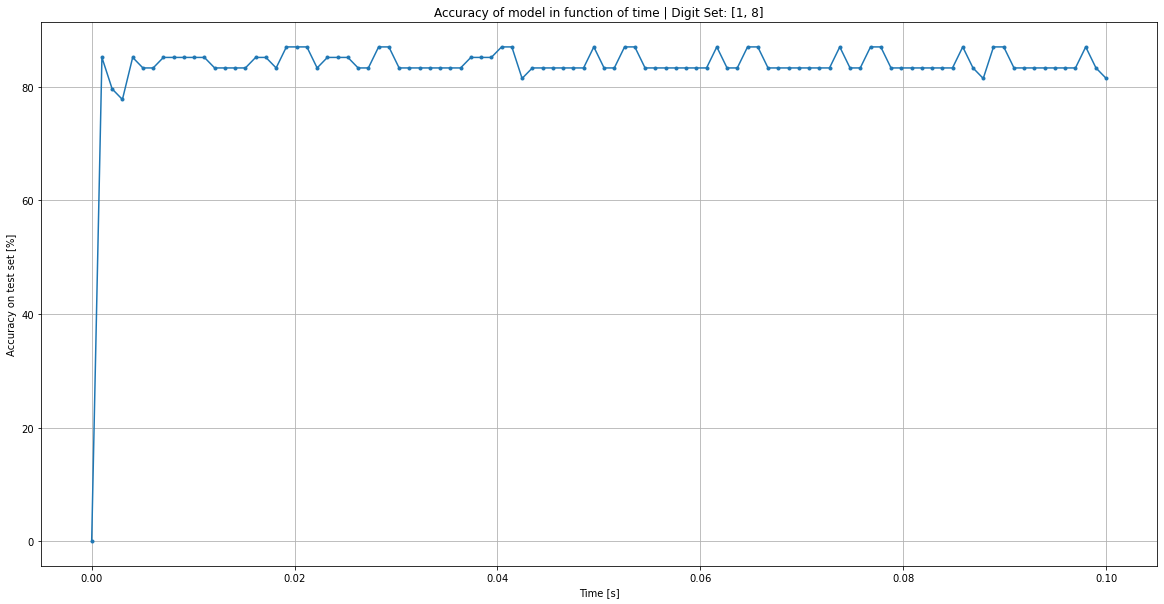

Testing Error: 17.0%


In [11]:
run([1,8])

**Training to Classify Digits: 3,8**

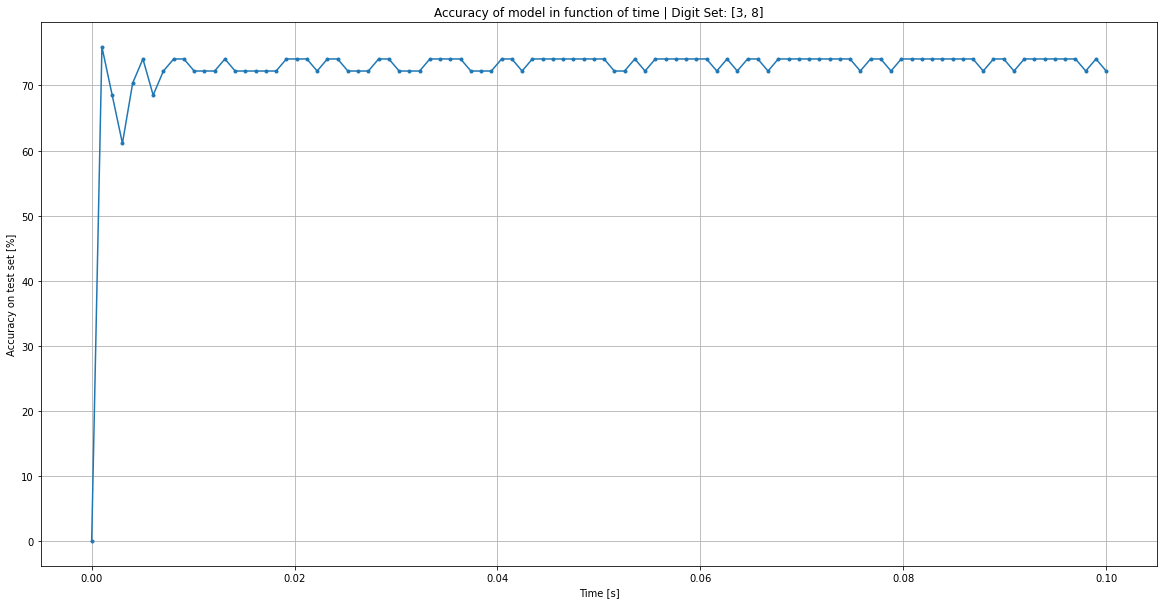

Testing Error: 35.0%


In [12]:
run([3,8])

Error increases on digits set 3,8 because 3 and 8 are more similar in terms of how they are written relative to digits 1 and 8 so I would expect our model to have done worse on the digits 3 and 8 which can be seen in these results. It is harder for the model to tell between 3 and 8 than 1 and 8 due to the similarity of 3 and 8.


**Training to Classify Digits: 0-9**

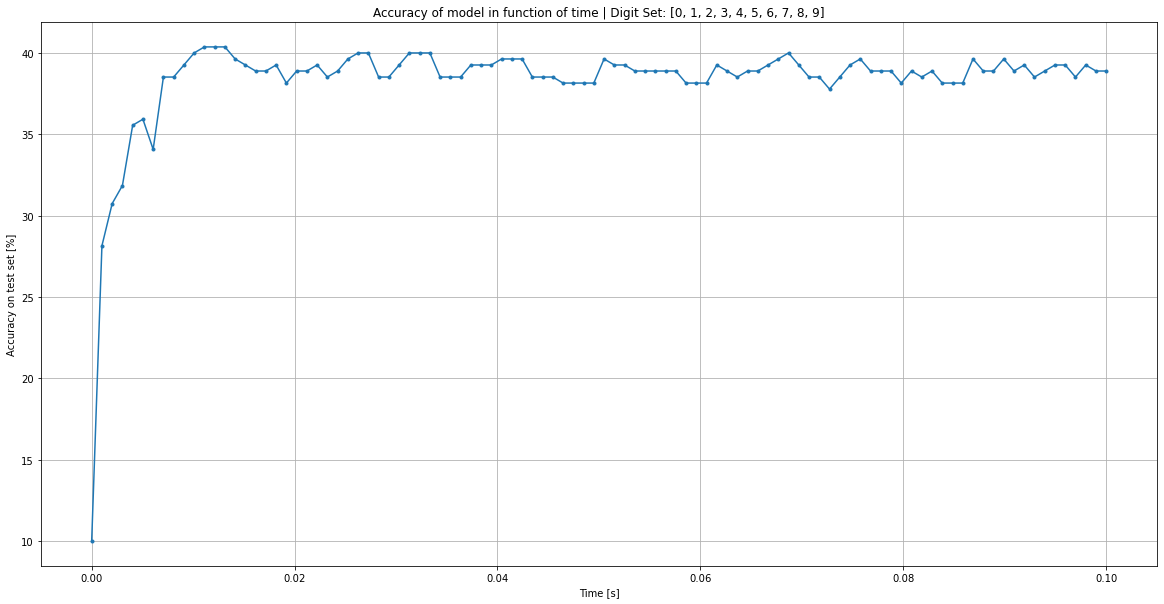

Testing Error: 55.0%


In [19]:
run([0,1,2,3,4,5,6,7,8,9])

Our model is better than 10% accuracy which is what you will expect to get if you digits were simply chosen at random.

References

- [1] Eliasmith, Chris, and Charles H. Anderson. Neural Engineering: Computation, Representation, and Dynamics in Neurobiological Systems. Mitt Press, 2003. 
- [2] Ali Safa. (2020, July 19). Digit Classification Using a One-Hidden-Layer Spiking Neural Network (Version V1.3). Zenodo. http://doi.org/10.5281/zenodo.3951585